<a href="https://colab.research.google.com/github/aaditya9803/ml/blob/main/Stroke_prediction_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
#Giving access to the metroPT3.csv in google coolab
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#Get the file
downloaded = drive.CreateFile({'id':'1WZT2g06H_SXu0q5PgTFXbbUVsP6MuWkU'})
downloaded.GetContentFile('dataset-stroke.csv')
model_file = drive.CreateFile({'id':'1aW64ncd1YncPEW0GWos3PjUeNaJcXMcq'})
model_file.GetContentFile('stroke_xgb_model.pkl')

In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVC
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import KFold
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import pickle

In [72]:
train_data = pd.read_csv(('dataset-stroke.csv'), sep=',', header=0)
df= df_for_decoding = pd.DataFrame(train_data)
df.isnull().sum()

,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,201


In [4]:
df['stroke'].value_counts()

,count
stroke,
0,4861
1,249


In [5]:
# df.dropna(inplace=True)
df['bmi'].fillna(df['bmi'].mean(), inplace=True)
df.isnull().sum()

<ipython-input-5-63b58b6543c6>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bmi'].fillna(df['bmi'].mean(), inplace=True)


,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,0


In [6]:
df['smoking_status'].value_counts()


,count
smoking_status,
never smoked,1892
Unknown,1544
formerly smoked,885
smokes,789


In [7]:
df_stroke = df[df['stroke'] == 1]
df_stroke.drop(columns='id', inplace=True)
df_stroke.head()

<ipython-input-7-ea978acf7272>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stroke.drop(columns='id', inplace=True)


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


In [8]:
df.drop(columns='id',inplace=True)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


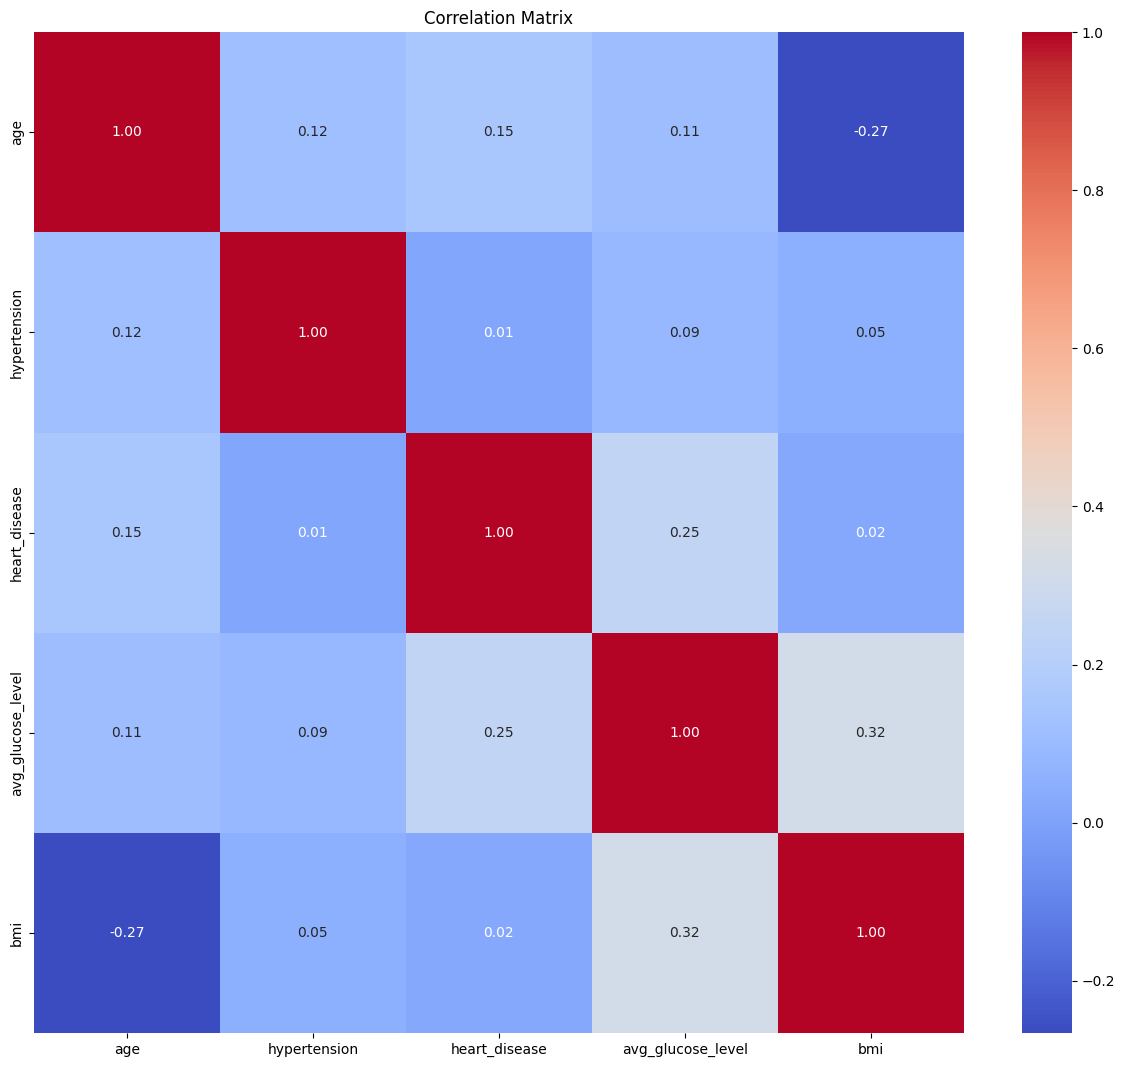

In [9]:
numerical_df = df_stroke.drop(columns='stroke').select_dtypes(include=['number'])
correlations = numerical_df.corr()
plt.figure(figsize=(15, 13))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

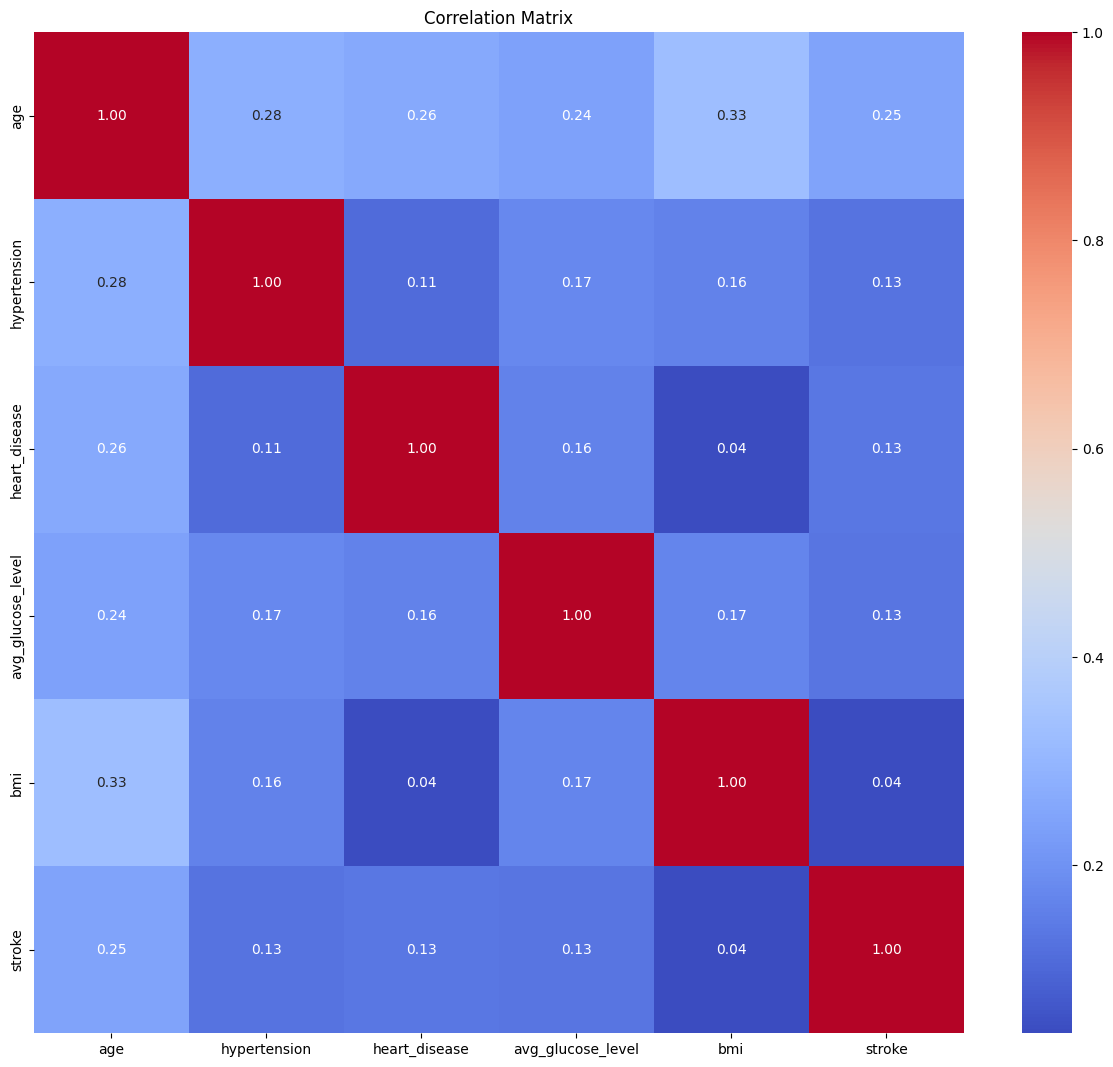

In [10]:
numerical_df = df.select_dtypes(include=['number'])
correlations = numerical_df.corr()
plt.figure(figsize=(15, 13))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [11]:
#Labelencoder
label_encoder = LabelEncoder()

columns_to_label = ['gender', 'ever_married', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

for column in columns_to_label:
    df[column] = df[column].astype(str)
    df_stroke[column] = df_stroke[column].astype(str)
    df[column] = label_encoder.fit_transform(df[column])
    df_stroke[column] = label_encoder.fit_transform(df_stroke[column])

df.head()

<ipython-input-11-92296cf5a319>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stroke[column] = df_stroke[column].astype(str)
<ipython-input-11-92296cf5a319>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stroke[column] = label_encoder.fit_transform(df_stroke[column])
<ipython-input-11-92296cf5a319>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.600000,1,1
1,0,61.0,0,0,1,3,0,202.21,28.893237,2,1
2,1,80.0,0,1,1,2,0,105.92,32.500000,2,1
3,0,49.0,0,0,1,2,1,171.23,34.400000,3,1
4,0,79.0,1,0,1,3,0,174.12,24.000000,2,1


In [12]:
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.600000,1,1
1,0,61.0,0,0,1,3,0,202.21,28.893237,2,1
2,1,80.0,0,1,1,2,0,105.92,32.500000,2,1
3,0,49.0,0,0,1,2,1,171.23,34.400000,3,1
4,0,79.0,1,0,1,3,0,174.12,24.000000,2,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,0,80.0,1,0,1,2,1,83.75,28.893237,2,0
5106,0,81.0,0,0,1,3,1,125.20,40.000000,2,0
5107,0,35.0,0,0,1,3,0,82.99,30.600000,2,0
5108,1,51.0,0,0,1,2,0,166.29,25.600000,1,0


In [13]:
df['stroke'].value_counts()

,count
stroke,
0,4861
1,249


In [14]:
# numerical_features = df.select_dtypes(include=['number'])
# sns.pairplot(numerical_features, diag_kind='kde')
# plt.show()

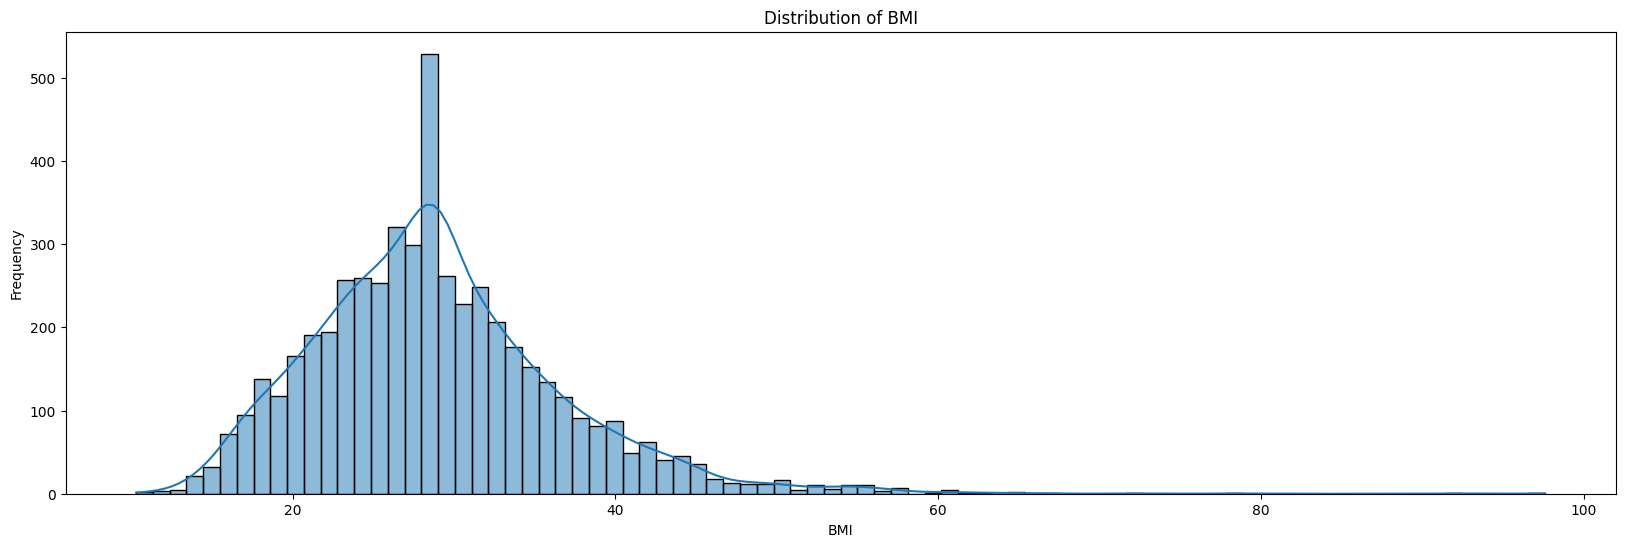

In [15]:
#Histogram
plt.figure(figsize=(20, 6))
sns.histplot(df['bmi'], kde=True)
plt.title('Distribution of BMI')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()

In [16]:
y = df['stroke']
X = df.drop(columns='stroke')

In [17]:
over = SMOTE(sampling_strategy = 1)
under = RandomUnderSampler(sampling_strategy = 0.1)
steps = [('under', under),('over', over)]
pipeline = Pipeline(steps=steps)
X, y = pipeline.fit_resample(X, y)
Counter(y)

Counter({0: 2490, 1: 2490})

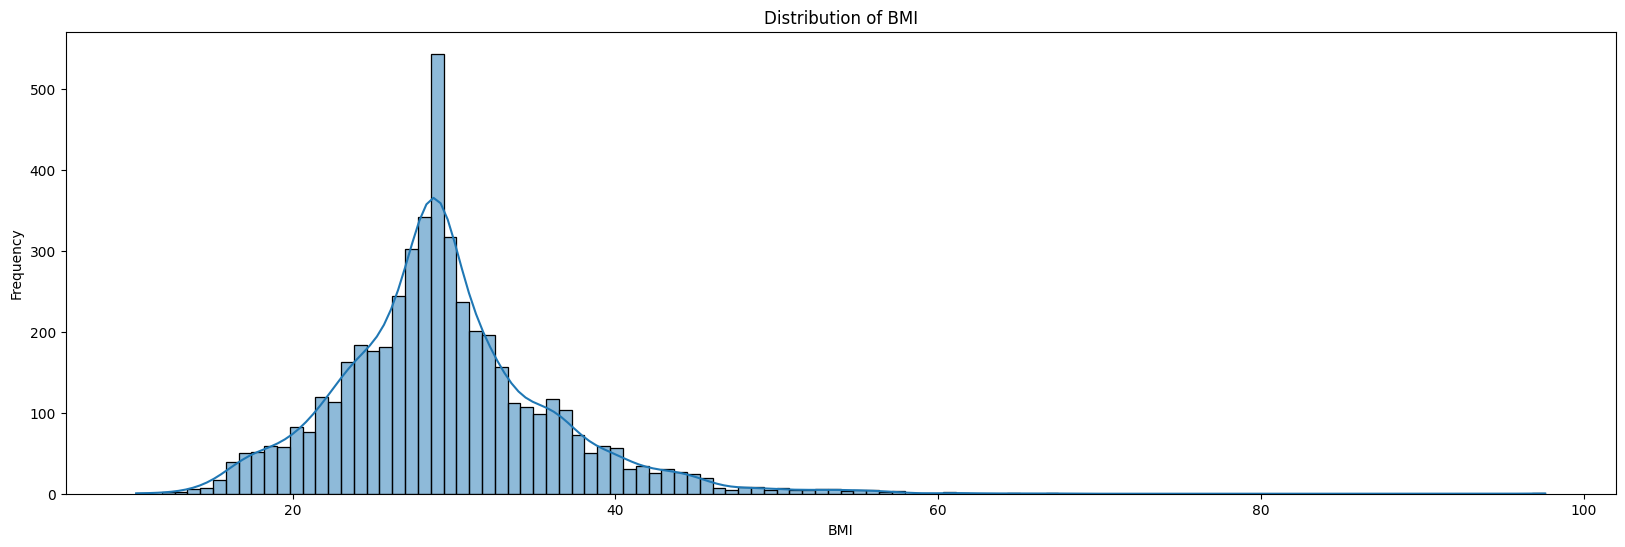

In [18]:
#Histogram
plt.figure(figsize=(20, 6))
sns.histplot(X['bmi'], kde=True)
plt.title('Distribution of BMI')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()

In [19]:
X

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,0,38.000000,0,0,1,2,0,66.160000,42.700000,0
1,0,76.000000,0,0,1,2,1,183.340000,39.500000,1
2,1,75.000000,0,0,1,0,0,93.930000,24.400000,1
3,1,82.000000,0,0,1,3,1,111.810000,19.800000,1
4,1,61.000000,0,0,1,0,1,107.330000,26.400000,1
...,...,...,...,...,...,...,...,...,...,...
4975,0,77.023213,0,0,1,2,0,59.326918,28.893237,1
4976,1,77.039784,0,0,1,2,0,245.955908,32.794167,1
4977,1,79.769666,0,0,1,2,1,215.368983,26.387078,0
4978,0,41.970921,0,0,1,2,0,83.388831,25.413085,0


In [20]:
y

,stroke
0,0
1,0
2,0
3,0
4,0
...,...
4975,1
4976,1
4977,1
4978,1


In [22]:
def xgb_(X, y, num_folds=5):


    print(X.shape)
    print(y.shape)

    kf = KFold(n_splits=num_folds, shuffle=True, random_state=24)

    f1_scores = []
    accuracies = []
    precisions = []

    for fold_idx, (train_idx, test_idx) in enumerate(kf.split(X)):
        print(f"Fold {fold_idx + 1}:")

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Initialize and train the XGBoost model with regularization
        xgb1 = xgb.XGBClassifier(
            objective="binary:logistic",
            random_state=42,
        )

        # Fit the model
        xgb1.fit(X_train.to_numpy(), y_train.to_numpy().ravel())

        # Make predictions
        y_pred = xgb1.predict(X_test.to_numpy())

        # Ensure y_test is 1D for comparison
        y_test = y_test.to_numpy().ravel().astype(int)
        y_pred = y_pred.astype(int)

        # Calculate and store F1-score for this fold
        f1 = f1_score(y_test, y_pred, average='weighted')
        f1_scores.append(f1)

        # Calculate and store accuracy and precision for this fold
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
        precision = precision_score(y_test, y_pred, average='weighted')
        precisions.append(precision)

        print(classification_report(y_test, y_pred))
        print(f"Fold {fold_idx + 1} F1-score: {f1:.4f}")
        print(f"Fold {fold_idx + 1} Accuracy: {accuracy:.4f}")
        print(f"Fold {fold_idx + 1} Precision: {precision:.4f}")

        # Calculate and print confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        print("Confusion Matrix:")
        print(cm)

        print("-" * 30)

    # Calculate and print average metrics across all folds
    avg_f1 = np.mean(f1_scores)
    avg_accuracy = np.mean(accuracies)
    avg_precision = np.mean(precisions)

    print(f"Average F1-score across {num_folds} folds: {avg_f1:.4f}")
    print(f"Average Accuracy across {num_folds} folds: {avg_accuracy:.4f}")
    print(f"Average Precision across {num_folds} folds: {avg_precision:.4f}")
    print("\n"*2)
    print(X.shape)
    print(y.shape)
    # Final model: Train on the entire dataset
    print("Training final model on the entire dataset...")


    X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X, y, test_size=0.2, random_state=42)

    # Final model with regularization
    final_model = xgb.XGBClassifier(
        objective="binary:logistic",
        random_state=42,
    )

    # Train on the entire dataset
    final_model.fit(X_train_final.to_numpy(), y_train_final.to_numpy().ravel())

    # Evaluate the final model on the test set
    y_pred_final = final_model.predict(X_test_final.to_numpy())

    # Calculate accuracy, precision, confusion matrix for final model
    final_accuracy = accuracy_score(y_test_final, y_pred_final)
    final_precision = precision_score(y_test_final, y_pred_final, average='weighted')
    final_cm = confusion_matrix(y_test_final, y_pred_final)

    print(f"Final Model Accuracy: {final_accuracy:.4f}")
    print(f"Final Model Precision: {final_precision:.4f}")
    print("Final Model Confusion Matrix:")
    print(final_cm)




In [23]:
xgb_(X, y)

(4980, 10)
(4980,)
Fold 1:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92       502
           1       0.90      0.95      0.93       494

    accuracy                           0.92       996
   macro avg       0.92      0.92      0.92       996
weighted avg       0.92      0.92      0.92       996

Fold 1 F1-score: 0.9237
Fold 1 Accuracy: 0.9237
Fold 1 Precision: 0.9249
Confusion Matrix:
[[451  51]
 [ 25 469]]
------------------------------
Fold 2:
              precision    recall  f1-score   support

           0       0.91      0.88      0.90       488
           1       0.89      0.91      0.90       508

    accuracy                           0.90       996
   macro avg       0.90      0.90      0.90       996
weighted avg       0.90      0.90      0.90       996

Fold 2 F1-score: 0.8986
Fold 2 Accuracy: 0.8986
Fold 2 Precision: 0.8988
Confusion Matrix:
[[431  57]
 [ 44 464]]
------------------------------
Fold 3:
             

In [40]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=24)
model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Train the model
model.fit(X, y)

# Make predictions on the test set
y_pred = model.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(model, file)

# Download the file
from google.colab import files
files.download('xgb_model.pkl')

Accuracy: 0.9947791164658635
Confusion Matrix:
[[1231   12]
 [   1 1246]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [38]:
#Testing all rows where stroke == 1


y_pred = model.predict(df_stroke.drop(columns='stroke'))

# Evaluate the model
accuracy = accuracy_score(df_stroke['stroke'], y_pred)
print(f"Accuracy: {accuracy}")

cm = confusion_matrix(df_stroke['stroke'], y_pred)
print("Confusion Matrix:")
print(cm)



Accuracy: 0.9879518072289156
Confusion Matrix:
[[  0   0]
 [  3 246]]


In [32]:
y

,stroke
0,0
1,0
2,0
3,0
4,0
...,...
4975,1
4976,1
4977,1
4978,1


In [42]:
X

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,0,38.000000,0,0,1,2,0,66.160000,42.700000,0
1,0,76.000000,0,0,1,2,1,183.340000,39.500000,1
2,1,75.000000,0,0,1,0,0,93.930000,24.400000,1
3,1,82.000000,0,0,1,3,1,111.810000,19.800000,1
4,1,61.000000,0,0,1,0,1,107.330000,26.400000,1
...,...,...,...,...,...,...,...,...,...,...
4975,0,77.023213,0,0,1,2,0,59.326918,28.893237,1
4976,1,77.039784,0,0,1,2,0,245.955908,32.794167,1
4977,1,79.769666,0,0,1,2,1,215.368983,26.387078,0
4978,0,41.970921,0,0,1,2,0,83.388831,25.413085,0


In [52]:

# # Generate labels for the new data
# new_data['predicted_labels'] = model.predict(new_data)

In [54]:
# y_pred = imported_model.predict(df_stroke.drop(columns='stroke'))

# # Evaluate the model
# accuracy = accuracy_score(df_stroke['stroke'], y_pred)
# print(f"Accuracy: {accuracy}")

# cm = confusion_matrix(df_stroke['stroke'], y_pred)
# print("Confusion Matrix:")
# print(cm)


In [64]:
df_stroke.drop(columns='stroke')

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,1,67.0,0,1,1,1,1,228.69,36.600000,1
1,0,61.0,0,0,1,2,0,202.21,28.893237,2
2,1,80.0,0,1,1,1,0,105.92,32.500000,2
3,0,49.0,0,0,1,1,1,171.23,34.400000,3
4,0,79.0,1,0,1,2,0,174.12,24.000000,2
...,...,...,...,...,...,...,...,...,...,...
244,1,57.0,0,0,1,1,0,84.96,36.700000,0
245,0,14.0,0,0,0,3,0,57.93,30.900000,0
246,0,75.0,0,0,1,2,0,78.80,29.300000,1
247,1,71.0,1,0,1,2,0,87.80,28.893237,0


## Manually testing

In [69]:
with open("stroke_xgb_model.pkl", "rb") as file:
    imported_model = pickle.load(file)

#FOR stroke = 0
x_values = np.array([[
    0, 38.000000, 0, 0, 1, 2, 0, 66.160000, 42.700000, 0
]])
print(imported_model.predict(x_values))


#FOR stroke = 0
x_values_2 = np.array([[
    0, 76.000000, 0, 0,	1, 2, 1, 183.340000, 39.500000, 1
]])
print(imported_model.predict(x_values_2))


#FOR stroke = 1
x_values_3 = np.array([[
    1,	67.0,	0,	1,	1,	1,	1,	228.69,	36.600000,	1
    ]])
print(imported_model.predict(x_values_3))

#FOR stroke = 1
x_values_4 = np.array([[
    0,	61.0,	0, 0,	1, 2,	0, 202.21, 28.893237, 2
    ]])
print(imported_model.predict(x_values_4))

[0]
[0]
[1]
[1]


## Reverse Labelling

In [77]:
label_encoder = LabelEncoder()

columns_to_label = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status',]

for column in columns_to_label:
    df_for_decoding[column] = df_for_decoding[column].astype(str)
    label_encoder.fit(df_for_decoding[column])


    print(f"Mapping for '{column}':")
    for original, encoded in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
        print(f"  {original} -> {encoded}")
    print()

Mapping for 'gender':
  Female -> 0
  Male -> 1
  Other -> 2

Mapping for 'ever_married':
  No -> 0
  Yes -> 1

Mapping for 'work_type':
  Govt_job -> 0
  Never_worked -> 1
  Private -> 2
  Self-employed -> 3
  children -> 4

Mapping for 'Residence_type':
  Rural -> 0
  Urban -> 1

Mapping for 'smoking_status':
  Unknown -> 0
  formerly smoked -> 1
  never smoked -> 2
  smokes -> 3

